# Cleaning data and the skies

## 📖 Background
Your are a data analyst at an environmental company. Your task is to evaluate ozone pollution across various regions.

You’ve obtained data from the U.S. Environmental Protection Agency (EPA), containing daily ozone measurements at monitoring stations across California. However, like many real-world datasets, it’s far from clean: there are missing values, inconsistent formats, potential duplicates, and outliers.

Before you can provide meaningful insights, you must clean and validate the data. Only then can you analyse it to uncover trends, identify high-risk regions, and assess where policy interventions are most urgently needed.

## 💾 The data
The data is a modified dataset from the U.S. Environmental Protection Agency ([EPA](https://www.epa.gov/outdoor-air-quality-data/download-daily-data)). 

#### Ozone contains the daily air quality summary statistics by monitor for the state of California for 2024. Each row contains the date and the air quality metrics per collection method and site
- "Date" - the calendar date with which the air quality values are associated
- "Source" - the data source: EPA's Air Quality System (AQS), or Airnow reports
- "Site ID" - the id for the air monitoring site
- "POC" - the id number for the monitor
- "Daily Max 8-hour Ozone Concentration" - the highest 8-hour value of the day for ozone concentration
- "Units" - parts per million by volume (ppm)
- "Daily AQI Value" - the highest air quality index value for the day, telling how clean or polluted the air is (a value of 50 represents good air quality, while a value above 300 is hazardous)
- "Local Site Name" - name of the monitoring site
- "Daily Obs Count" - number of observations reported in that day
- "Percent Complete" - indicates whether all expected samples were collected
- "Method Code" - identifier for the collection method
- "CBSA Code" - identifier for the core base statistical area (CBSA)
- "CBSA Name" - name of the core base statistical area
- "State FIPS Code" - identifier for the state
- "State" - name of the state
- "County FIPS Code" - identifer for the county
- "County" - name of the county
- "Site Latitude" - latitude coordinates of the site
- "Site Longitude" - longitude coordinates of the side

# Executive Summary

Analysis of California's 2024 ozone monitoring data identifies significant regional air quality disparities requiring immediate policy intervention. Central Valley and Inland Empire regions experience the most severe pollution, with Visalia-Porterville recording unhealthy ozone levels on 19.8% of days.

## Key Findings

- **Highest risk areas**: Central Valley Air Basin (Tulare, Kern, Fresno counties) and Inland Empire (San Bernardino, Riverside counties)
- **Peak concentrations**: San Bernardino County averages 0.0553 ppm, with summer levels 40-50% higher than winter
- **Population exposure**: Nearly one in five days reach unhealthy levels in worst-affected regions during peak season
- **Overall status**: 93.8% of monitoring sites maintain EPA "Good" air quality standards annually

## Priority Interventions

**Immediate Actions Required:**
- Agricultural emission controls in Central Valley counties
- Enhanced goods movement standards in Inland Empire
- Real-time air quality alert systems for vulnerable populations
- Standardised monitoring protocols across all sites

Targeted policy interventions in identified hotspots can significantly reduce health risks for California's most vulnerable communities.

# Libraries

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import requests
import zipfile
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

ozone = pd.read_csv(Path.cwd().parent / 'data/ozone.csv')
ozone.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


# Exploratory Data Analysis (EDA)

## Data Summary

Let's examine our ozone dataset to understand its structure, dimensions, and potential issues before performing any analysis.

In [2]:
ozone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54759 entries, 0 to 54758
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  54759 non-null  object 
 1   Source                                54759 non-null  object 
 2   Site ID                               54759 non-null  int64  
 3   POC                                   54759 non-null  int64  
 4   Daily Max 8-hour Ozone Concentration  52021 non-null  float64
 5   Units                                 54759 non-null  object 
 6   Daily AQI Value                       52021 non-null  float64
 7   Local Site Name                       54759 non-null  object 
 8   Daily Obs Count                       54759 non-null  int64  
 9   Percent Complete                      54759 non-null  float64
 10  Method Code                           48269 non-null  float64
 11  CBSA Code      

The dataset contains 54,759 rows and 16 columns, representing daily ozone measurements from various monitoring stations across California for 2024. Key observations:

- **Missing Values**: There are some missing values in the "Daily Max 8-hour Ozone Concentration" column and the same amount in "Daily AQI Value", indicating these metrics are directly related.
  
- **Measurement Methods**: "Method Code" also has missing values, suggesting incomplete documentation of collection methodologies.

## Statistical Summary

Let's examine the key statistical characteristics of our dataset to understand the distribution of ozone measurements and other numerical variables. This will help identify potential outliers and understand the central tendencies of our data. It will also help us determine what values might be considered normal versus anomalous in our dataset.



In [3]:
ozone.describe()

,Site ID,POC,Daily Max 8-hour Ozone Concentration,Daily AQI Value,Daily Obs Count,Percent Complete,Method Code,CBSA Code,County FIPS Code,Site Latitude,Site Longitude
count,5.475900e+04,54759.000000,52021.000000,52021.000000,54759.000000,54759.000000,48269.000000,52351.000000,54759.000000,54759.000000,54759.000000
mean,6.059086e+07,1.000256,0.043519,45.280079,27.534688,99.340346,89.051669,36107.577697,58.918406,36.169550,-119.665107
std,3.001943e+05,0.015988,0.014610,25.899065,97.800446,3.658452,36.636778,9536.717562,30.012874,2.192841,2.022987
min,6.001001e+07,1.000000,0.000000,0.000000,1.000000,6.000000,47.000000,12540.000000,1.000000,32.578165,-124.179490
25%,6.031100e+07,1.000000,0.034000,31.000000,17.000000,100.000000,87.000000,31080.000000,31.000000,34.181977,-121.420838
50%,6.065500e+07,1.000000,0.041000,38.000000,17.000000,100.000000,87.000000,40140.000000,65.000000,36.209286,-119.828400
75%,6.081100e+07,1.000000,0.052000,48.000000,17.000000,100.000000,87.000000,41860.000000,81.000000,37.961578,-118.068500
max,6.113100e+07,2.000000,0.139000,236.000000,1000.000000,100.000000,199.000000,49700.000000,113.000000,41.726892,-114.602090


The statistical analysis reveals important characteristics of our key measurements:

- **Ozone Concentration**: 
  - Range: 0 to 0.1390 ppm
  - Mean: 0.043519 ppm
  - Median (50%): 0.0410 ppm
  - The min range (0 ppm) might be missing values or days with no ozone detected
  - The mean (0.0435 ppm) and median (0.0410 ppm) are very close, which suggests a nearly symmetric distribution

- **Daily AQI Value**:
  - Range: 0 to 236
  - Mean: 45.28
  - Median (50%): 38
  - Most values fall within acceptable air quality ranges, but some extreme values (236) indicate hazardous conditions

- **Daily Obs Count**:
  - Range: 1 to 1000
  - Mean: 27.5347
  - Median (50%): 17
  - The maximum daily observation count of 1000 is an outlier, suggesting a deeper investigation

- **Geographic Coverage**:
  - Sites spread across latitudes (32.58°N to 41.73°N) and longitudes (-124.18°E to -114.60°E)
  - This covers the entire state of California from the coast to inland regions

- **Data Completeness**:
  - Most measurements show 100% completeness (mean 99.34%)

This initial analysis suggests the data is generally reliable with some outliers that warrant further investigation, especially in the high AQI ranges and daily observation counts.

## Fix Date Format and Add Derived Date Features

In [4]:
# Convert Date column to datetime
ozone['Date'] = pd.to_datetime(ozone['Date'], errors='coerce')

# Check for any invalid dates that couldn't be parsed
invalid_dates = ozone['Date'].isna().sum()
print(f"Number of invalid dates: {invalid_dates}")

# Add derived date features for analysis
ozone['DayOfWeek'] = ozone['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
ozone['IsWeekend'] = ozone['DayOfWeek'].isin([5, 6])  # Saturday and Sunday
ozone.drop(columns=['DayOfWeek'], inplace=True)  # Drop if not needed

print(f"\nDate range: {ozone['Date'].min()} to {ozone['Date'].max()}")
ozone.head(3)

Number of invalid dates: 0

Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude,IsWeekend
0,2024-01-01,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217,False
1,2024-01-02,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217,False
2,2024-01-01,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217,False


## Missing Values

In [5]:
ozone.isna().sum()

Date                                       0
Source                                     0
Site ID                                    0
POC                                        0
Daily Max 8-hour Ozone Concentration    2738
Units                                      0
Daily AQI Value                         2738
Local Site Name                            0
Daily Obs Count                            0
Percent Complete                           0
Method Code                             6490
CBSA Code                               2408
CBSA Name                               2408
County FIPS Code                           0
County                                     0
Site Latitude                              0
Site Longitude                             0
IsWeekend                                  0
dtype: int64

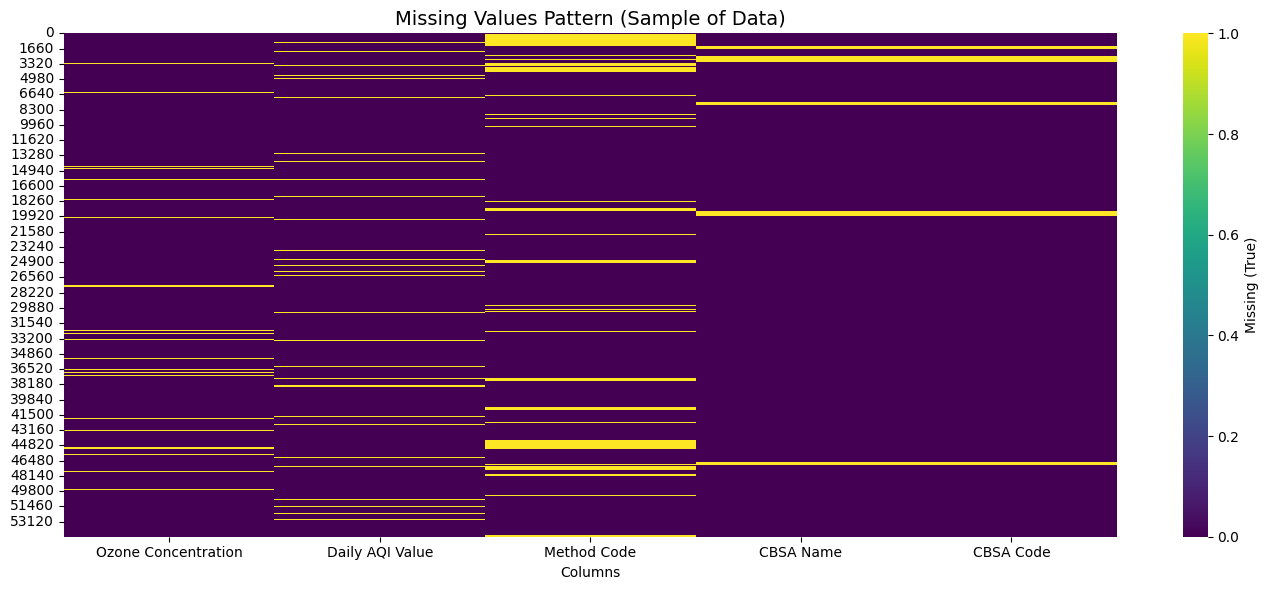


Missing Values Percentage:
Ozone Concentration     5.00
Daily AQI Value         5.00
Method Code            11.85
CBSA Name               4.40
CBSA Code               4.40
dtype: float64


In [6]:
# Create a mask for missing values in the dataset (True for missing, False for present)
missing_mask = ozone.isna()

# Select only the columns with missing values for the visualisation
columns_with_missing = ['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Method Code', 'CBSA Name', 'CBSA Code']
missing_subset = missing_mask[columns_with_missing].rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'})

# Calculate the percentage of missing values per column
missing_percentages = round(missing_subset.mean() * 100, 2)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Missing values heatmap
sns.heatmap(missing_subset, cmap='viridis', cbar_kws={'label': 'Missing (True)'})
ax.set_title('Missing Values Pattern (Sample of Data)', fontsize=14)
ax.set_xlabel('Columns')

plt.tight_layout()
plt.show()

print("\nMissing Values Percentage:")
print(missing_percentages)

In [7]:
# Check for rows where both ozone concentration and AQI values are missing
both_missing = ozone[ozone['Daily Max 8-hour Ozone Concentration'].isna() & ozone['Daily AQI Value'].isna()]

# Count how many rows have both values missing
print(f"Number of rows with both ozone concentration and AQI missing: {len(both_missing)}")

# Check if there are rows where only one value is missing
only_ozone_missing = ozone[ozone['Daily Max 8-hour Ozone Concentration'].isna() & ~ozone['Daily AQI Value'].isna()]
only_aqi_missing = ozone[~ozone['Daily Max 8-hour Ozone Concentration'].isna() & ozone['Daily AQI Value'].isna()]

print(f"Number of rows with only ozone concentration missing: {len(only_ozone_missing)}")
print(f"Number of rows with only AQI missing: {len(only_aqi_missing)}")

# Check for misalignment between ozone concentration and AQI values
# (when one exists but the other doesn't)
misaligned = len(only_ozone_missing) + len(only_aqi_missing)
print(f"Total rows with misaligned data: {misaligned}")

# Display a sample of misaligned data
if len(only_ozone_missing) > 0:
  print("\nSample where ozone is missing but AQI exists:")
  print(only_ozone_missing[['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Local Site Name']].head(3).rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'}))

if len(only_aqi_missing) > 0:
  print("\nSample where AQI is missing but ozone exists:")
  print(only_aqi_missing[['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Local Site Name']].head(3).rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'}))

Number of rows with both ozone concentration and AQI missing: 136
Number of rows with only ozone concentration missing: 2602
Number of rows with only AQI missing: 2602
Total rows with misaligned data: 5204

Sample where ozone is missing but AQI exists:
         Date  Ozone Concentration  Daily AQI Value Local Site Name
2  2024-01-01                  NaN             30.0       Livermore
39 2024-01-15                  NaN             21.0         Oakland
67 2024-02-12                  NaN             19.0         Oakland

Sample where AQI is missing but ozone exists:
         Date  Ozone Concentration  Daily AQI Value Local Site Name
12 2024-01-13                0.032              NaN       Livermore
25 2024-01-01                0.024              NaN         Oakland
63 2024-01-01                0.029              NaN         Oakland


## Handling Missing Values

Since AQI values are calculated from ozone concentrations (and vice versa) using EPA conversion formulas, we can use one to derive the other. For records where both values are missing (136 rows, representing just 0.25% of our dataset), we'll remove these rows rather than imputing values, which could introduce bias.

U.S. Environment Protection Agency (EPA) standard breakpoints for ozone:
  AQI Category    | Index Values | Ozone (ppm, 8-hour)
  ---------------|-------------|------------------
  Good           | 0-50        | 0-0.054
  Moderate       | 51-100      | 0.055-0.070
  Unhealthy for Sensitive Groups | 101-150     | 0.071-0.085
  Unhealthy      | 151-200     | 0.086-0.105
  Very Unhealthy | 201-300     | 0.106-0.200
  Hazardous      | 301-500     | 0.201-0.604

In [8]:
def convert_ozone_aqi(value, reverse=False):
  """
  Convert between ozone concentration (ppm) and AQI values.
  
  Parameters
  ----------
  value : float
    The value to convert. Either ozone concentration (ppm) or AQI value.
  reverse : bool, optional
    If False (default), convert from ozone concentration to AQI.
    If True, convert from AQI to ozone concentration.
    
  Returns
  -------
  float
    The converted value. Either AQI value or ozone concentration (ppm).
    Returns None if the input is outside the valid range.
  
  Notes
  -----
  Formula for conversion:
  AQI = ((I_high - I_low) / (C_high - C_low)) * (C - C_low) + I_low
  Where:
  - I_high, I_low: AQI breakpoints
  - C_high, C_low: Concentration breakpoints
  - C: Concentration to convert
  """
  # Define breakpoints for ozone concentration (ppm) and AQI
  breakpoints = [
    (0.000, 0.054, 0, 50),    # Good
    (0.055, 0.070, 51, 100),  # Moderate
    (0.071, 0.085, 101, 150), # Unhealthy for Sensitive Groups
    (0.086, 0.105, 151, 200), # Unhealthy
    (0.106, 0.200, 201, 300), # Very Unhealthy
    (0.201, 0.604, 301, 500)  # Hazardous
  ]
  
  if not reverse:  # Ozone concentration to AQI
    if value is None or value < 0:
      return None
      
    # Find the appropriate breakpoint range
    for c_low, c_high, i_low, i_high in breakpoints:
      if c_low <= value <= c_high:
        # Apply the formula for converting concentration to AQI
        aqi = ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
        return round(aqi)
        
    # If value is above the highest range
    if value > breakpoints[-1][1]:
      return 500  # Maximum AQI value
    return 0  # Default for very low values
    
  else:  # AQI to ozone concentration
    if value is None or value < 0 or value > 500:
      return None
      
    # Find the appropriate breakpoint range
    for c_low, c_high, i_low, i_high in breakpoints:
      if i_low <= value <= i_high:
        # Apply the formula for converting AQI to concentration
        conc = ((c_high - c_low) / (i_high - i_low)) * (value - i_low) + c_low
        return round(conc, 4)
        
    return 0  # Default for very low values

In [9]:
# First, handle missing values where both concentration and AQI are null
# These records can't be reliably filled, so we'll drop them
print("Number of records before dropping rows with both values missing:", len(ozone))
ozone_clean = ozone.dropna(subset=['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value'], how='all')
print("Number of records after dropping rows with both values missing:", len(ozone_clean))

# For records where only one value is missing, use the conversion function to fill in the other
# Where Ozone Concentration exists but AQI is missing
mask_fill_aqi = ozone_clean['Daily Max 8-hour Ozone Concentration'].notna() & ozone_clean['Daily AQI Value'].isna()
ozone_clean.loc[mask_fill_aqi, 'Daily AQI Value'] = ozone_clean.loc[mask_fill_aqi, 'Daily Max 8-hour Ozone Concentration'].apply(convert_ozone_aqi)

# Where AQI exists but Ozone Concentration is missing
mask_fill_ozone = ozone_clean['Daily Max 8-hour Ozone Concentration'].isna() & ozone_clean['Daily AQI Value'].notna()
ozone_clean.loc[mask_fill_ozone, 'Daily Max 8-hour Ozone Concentration'] = ozone_clean.loc[mask_fill_ozone, 'Daily AQI Value'].apply(lambda x: convert_ozone_aqi(x, reverse=True))

# Check if there are still missing values after filling
missing_after = ozone_clean[['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value']].isna().sum()
print("\nRemaining missing values after filling:")
print(missing_after)

# Verify with a sample of records that were filled
print("\nSample of records where AQI was calculated from ozone concentration:")
print(ozone_clean.loc[mask_fill_aqi].head(3)[['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Local Site Name']].rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'}))

print("\nSample of records where ozone concentration was calculated from AQI:")
print(ozone_clean.loc[mask_fill_ozone].head(3)[['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Local Site Name']].rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'}))

# Verify the relationship between concentration and AQI with a sample of filled values
sample_size = min(10, len(mask_fill_aqi[mask_fill_aqi]), len(mask_fill_ozone[mask_fill_ozone]))
fill_comparison = pd.DataFrame({
  'Original Ozone': ozone_clean.loc[mask_fill_aqi, 'Daily Max 8-hour Ozone Concentration'].head(sample_size),
  'Calculated Ozone': ozone_clean.loc[mask_fill_ozone, 'Daily Max 8-hour Ozone Concentration'].head(sample_size),
  'Original AQI': ozone_clean.loc[mask_fill_ozone, 'Daily AQI Value'].head(sample_size),
  'Calculated AQI': ozone_clean.loc[mask_fill_aqi, 'Daily AQI Value'].head(sample_size),
})

print("\nComparison of original and calculated values:")
print(fill_comparison)

Number of records before dropping rows with both values missing: 54759
Number of records after dropping rows with both values missing: 54623

Remaining missing values after filling:
Daily Max 8-hour Ozone Concentration    0
Daily AQI Value                         0
dtype: int64

Sample of records where AQI was calculated from ozone concentration:
         Date  Ozone Concentration  Daily AQI Value Local Site Name
12 2024-01-13                0.032             30.0       Livermore
25 2024-01-01                0.024             22.0         Oakland
63 2024-01-01                0.029             27.0         Oakland

Sample of records where ozone concentration was calculated from AQI:
         Date  Ozone Concentration  Daily AQI Value Local Site Name
2  2024-01-01               0.0324             30.0       Livermore
39 2024-01-15               0.0227             21.0         Oakland
67 2024-02-12               0.0205             19.0         Oakland

Comparison of original and calculate

## Feature Selection

In [10]:
# First, let's see all column names
print("All columns in the dataset:")
print(ozone_clean.columns)

All columns in the dataset:
Index(['Date', 'Source', 'Site ID', 'POC',
       'Daily Max 8-hour Ozone Concentration', 'Units', 'Daily AQI Value',
       'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'Method Code',
       'CBSA Code', 'CBSA Name', 'County FIPS Code', 'County', 'Site Latitude',
       'Site Longitude', 'IsWeekend'],
      dtype='object')


In [11]:
print("\n" + "="*50)
print("Column analysis for potential removal:")

print("\n1. Source column:")
print(f"Unique values: {ozone_clean['Source'].unique()}")
print(f"Value counts: {ozone_clean['Source'].value_counts()}")

print("\n2. POC column (Parameter Occurrence Code):")
print(f"Unique values: {ozone_clean['POC'].unique()}")
print(f"Value counts: {ozone_clean['POC'].value_counts()}")

print("\n3. Units column:")
print(f"Unique values: {ozone_clean['Units'].unique()}")
print(f"Value counts: {ozone_clean['Units'].value_counts()}")

print("\n4. Method Code:")
print(f"Unique values: {ozone_clean['Method Code'].unique()}")
print(f"Value counts: {ozone_clean['Method Code'].value_counts()}")


Column analysis for potential removal:

1. Source column:
Unique values: ['AQS' 'AirNow']
Value counts: Source
AQS       48150
AirNow     6473
Name: count, dtype: int64

2. POC column (Parameter Occurrence Code):
Unique values: [1 2]
Value counts: POC
1    54609
2       14
Name: count, dtype: int64

3. Units column:
Unique values: ['ppm']
Value counts: Units
ppm    54623
Name: count, dtype: int64

4. Method Code:
Unique values: [ 47.  nan  87. 199.  53.]
Value counts: Method Code
87.0     35187
47.0      8525
199.0     4047
53.0       391
Name: count, dtype: int64


Based on the analysis of column uniqueness and value counts, 'Units' column contains only 'ppm' (parts per million) for all records. Since all measurements use the same unit, this column adds no analytical value and can be safely removed. 

### Remove Columns

Along with 'Units' column, 'CBSA Code' and 'County FIPS Code' can be safely removed because they represent the 'CBSA Name' and 'County' columns in numerical format, which is redundant.

In [12]:
ozone_reduced = ozone_clean.drop(columns=['Units', 'CBSA Code', 'County FIPS Code'])
ozone_reduced.head(3)

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Name,County,Site Latitude,Site Longitude,IsWeekend
0,2024-01-01,AQS,60010007,1,0.0310,29.0,Livermore,17,100.0,47.0,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217,False
1,2024-01-02,AQS,60010007,1,0.0370,34.0,Livermore,17,100.0,47.0,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217,False
2,2024-01-01,AQS,60010007,1,0.0324,30.0,Livermore,17,100.0,47.0,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217,False


## Identify Outliers

Before proceeding with detailed analysis, we need to identify outliers in our key numerical variables: 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', and 'Daily Obs Count'. These outliers could represent either data errors or important extreme air quality events. We'll use boxplots to visualise the distribution of these key metrics and identify statistical outliers.

<Figure size 1600x1200 with 0 Axes>

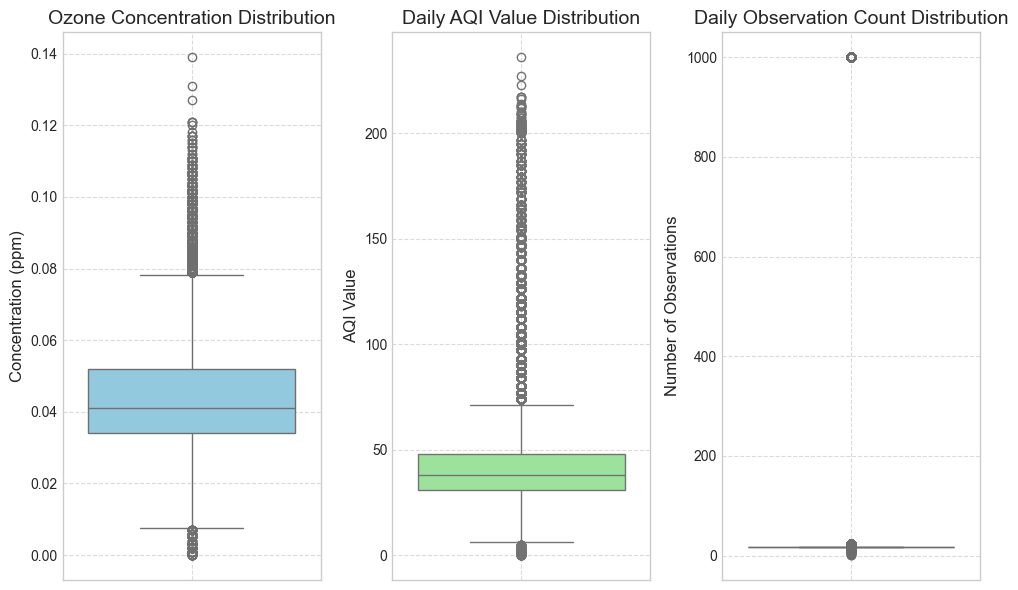

In [13]:
# Set the style for better visualisation
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 12))

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

# Plot 1: Boxplot for Daily Max 8-hour Ozone Concentration
sns.boxplot(y='Daily Max 8-hour Ozone Concentration', data=ozone_reduced, ax=axes[0], color='skyblue')
axes[0].set_title('Ozone Concentration Distribution', fontsize=14)
axes[0].set_ylabel('Concentration (ppm)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Boxplot for Daily AQI Value
sns.boxplot(y='Daily AQI Value', data=ozone_reduced, ax=axes[1], color='lightgreen')
axes[1].set_title('Daily AQI Value Distribution', fontsize=14)
axes[1].set_ylabel('AQI Value', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Boxplot for Daily Obs Count
sns.boxplot(y='Daily Obs Count', data=ozone_reduced, ax=axes[2], color='salmon')
axes[2].set_title('Daily Observation Count Distribution', fontsize=14)
axes[2].set_ylabel('Number of Observations', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [14]:
# Print summary statistics of potential outliers
print("\nOutlier Analysis Summary:")
print("-" * 80)
print("Total records:", len(ozone_reduced))
print(f"Ozone Concentration > 0.070 ppm (Unhealthy for Sensitive Groups): {len(ozone_reduced[ozone_reduced['Daily Max 8-hour Ozone Concentration'] > 0.070])} records")
print(f"Ozone Concentration > 0.086 ppm (Unhealthy): {len(ozone_reduced[ozone_reduced['Daily Max 8-hour Ozone Concentration'] > 0.086])} records")
print(f"AQI Value > 100 (Unhealthy for Sensitive Groups): {len(ozone_reduced[ozone_reduced['Daily AQI Value'] > 100])} records")
print(f"AQI Value > 150 (Unhealthy): {len(ozone_reduced[ozone_reduced['Daily AQI Value'] > 150])} records")
print(f"Daily Obs Count = 1000: {len(ozone_reduced[ozone_reduced['Daily Obs Count'] == 1000])} records")


Outlier Analysis Summary:
--------------------------------------------------------------------------------
Total records: 54623
Ozone Concentration > 0.070 ppm (Unhealthy for Sensitive Groups): 2735 records
Ozone Concentration > 0.086 ppm (Unhealthy): 528 records
AQI Value > 100 (Unhealthy for Sensitive Groups): 2735 records
AQI Value > 150 (Unhealthy): 584 records
Daily Obs Count = 1000: 547 records


The boxplots reveal interesting patterns in our data distribution:

- **Ozone Concentration**: Shows some higher values (potential outliers) above 0.12 ppm, which corresponds to "Very Unhealthy" per EPA standards. These aren't likely errors, but rather genuine high pollution events that warrant investigation.

- **AQI Values**: Similarly shows higher values above 220, which aligns with the ozone concentration patterns. These higher values represent actual poor air quality days rather than data errors.

- **Daily Observation Count**: Displays a dramatic bimodal distribution with most values below 50, but a significant cluster at exactly 1000 observations (547 records). This suggests two distinct data collection protocols rather than erroneous values.

### Digging into 1000 Daily Observations

In [15]:
# Filter records with 1000 daily observation counts
ozone_higher_daily_obs = ozone_reduced[ozone_reduced['Daily Obs Count'] == 1000]

# Check the source and statistical summary of these records
print(ozone_higher_daily_obs['Source'].value_counts())
ozone_higher_daily_obs.describe()

Source
AQS       475
AirNow     72
Name: count, dtype: int64


,Date,Site ID,POC,Daily Max 8-hour Ozone Concentration,Daily AQI Value,Daily Obs Count,Percent Complete,Method Code,Site Latitude,Site Longitude
count,547,5.470000e+02,547.0,547.000000,547.000000,547.0,547.000000,475.000000,547.000000,547.000000
mean,2024-05-30 22:54:11.188300032,6.060464e+07,1.0,0.043208,45.082267,1000.0,99.433272,90.360000,36.202021,-119.750598
min,2024-01-01 00:00:00,6.001001e+07,1.0,0.010000,9.000000,1000.0,75.000000,47.000000,32.578165,-124.179490
25%,2024-02-06 00:00:00,6.033300e+07,1.0,0.034000,31.000000,1000.0,100.000000,87.000000,34.252390,-121.368014
50%,2024-05-25 00:00:00,6.067001e+07,1.0,0.042000,39.000000,1000.0,100.000000,87.000000,36.209286,-119.874739
75%,2024-09-09 12:00:00,6.083101e+07,1.0,0.051000,47.000000,1000.0,100.000000,87.000000,37.972310,-118.207905
max,2024-12-29 00:00:00,6.113100e+07,1.0,0.108000,203.000000,1000.0,100.000000,199.000000,41.726892,-114.602090
std,NaN,3.038025e+05,0.0,0.014765,26.492217,0.0,3.303987,38.309572,2.133997,1.975573


The 1000 observation records appear across multiple monitoring sites and sources with mostly 100% completeness, indicating a systematic difference in measurement methodology rather than data entry errors.

## Time Series Analysis

In [16]:
def plot_time_series(df: pd.DataFrame, col_name: str, title: str | None = None, y_label: str | None = None, reference_lines: dict | None = None, rolling_window: int = 7):
      """
      Creates a time series plot with a rolling average for a specified column.
      
      Parameters:
      -----------
      df : pandas.DataFrame
            The dataframe containing the time series data
      col_name : str
            The name of the column to plot
      title : str, optional
            The title for the plot
      y_label : str, optional
            The label for the y-axis
      reference_lines : dict, optional
            Dictionary with threshold values as keys and tuple of (color, label) as values
      rolling_window : int, optional
            Window size for the rolling average, default is 7 days
      """
      # Set the style for better visualisation
      plt.style.use('seaborn-v0_8-whitegrid')
      
      # Create the figure
      plt.figure(figsize=(14, 7))
      
      # Group by date and calculate mean for the column
      daily_avg = df.groupby('Date')[col_name].mean().reset_index()
      
      # Sort by date to ensure proper time sequence
      daily_avg = daily_avg.sort_values('Date')
      
      # Calculate rolling average
      rolling_col = f'{rolling_window}-Day MA'
      daily_avg[rolling_col] = daily_avg[col_name].rolling(window=rolling_window, center=False).mean()
      
      # Plot raw data as light points
      plt.scatter(daily_avg['Date'], daily_avg[col_name], 
                        alpha=0.3, s=15, color='skyblue', label=f'Daily Average')
      
      # Plot the rolling average as a bold line
      plt.plot(daily_avg['Date'], daily_avg[rolling_col], 
                   linewidth=2.5, color='darkblue', label=f'{rolling_window}-Day Moving Average')
      
      # Add reference lines if provided
      if reference_lines:
            for threshold, (color, label) in reference_lines.items():
                  plt.axhline(y=threshold, color=color, linestyle='--', alpha=0.7, label=label)
                  # Add text annotation
                  plt.text(daily_avg['Date'].max(), threshold + 0.002, label, 
                               fontsize=9, va='bottom', ha='right', color=color.replace('yellow', 'darkgoldenrod'))
      
      # Customize the plot
      plt.title(title or f'Daily {col_name} with {rolling_window}-Day Moving Average', fontsize=16)
      plt.xlabel('Date', fontsize=12)
      plt.ylabel(y_label or col_name, fontsize=12)
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.legend(loc='upper left')
      
      # Format x-axis to show months
      plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
      plt.xticks(rotation=45)
      
      plt.tight_layout()
      plt.show()
      
      return daily_avg

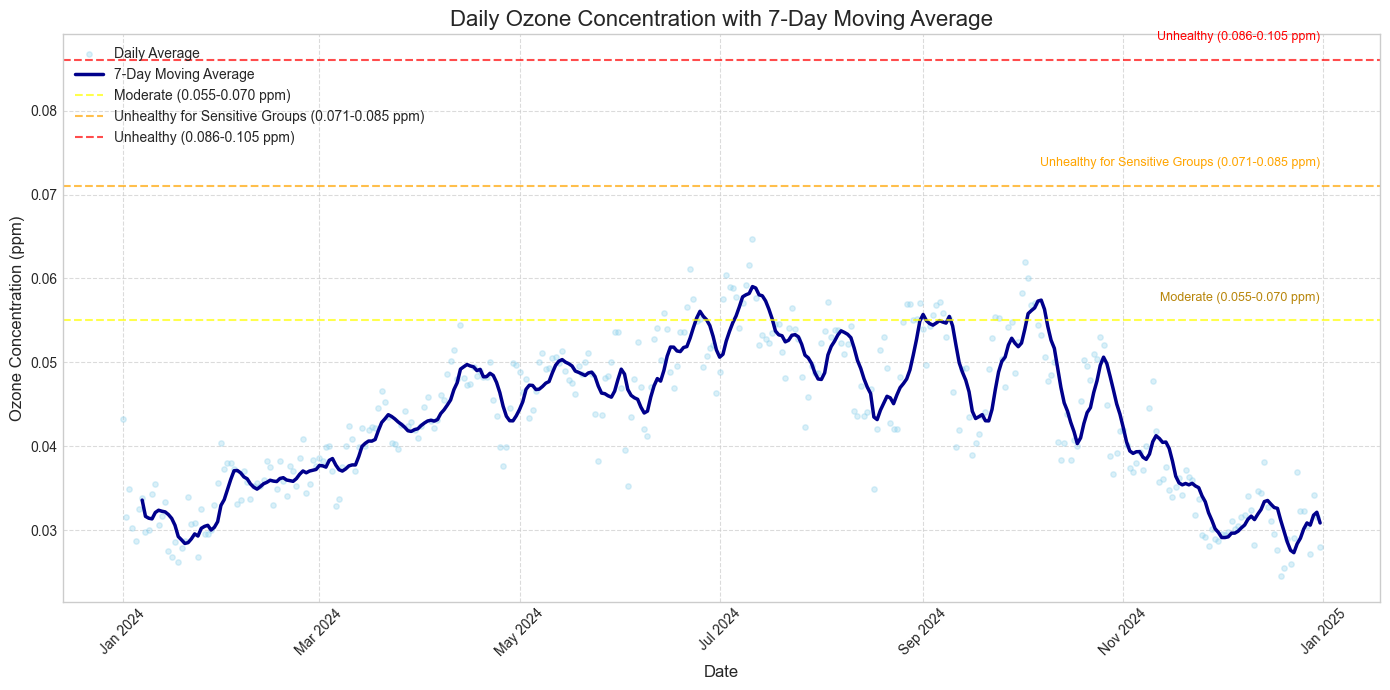

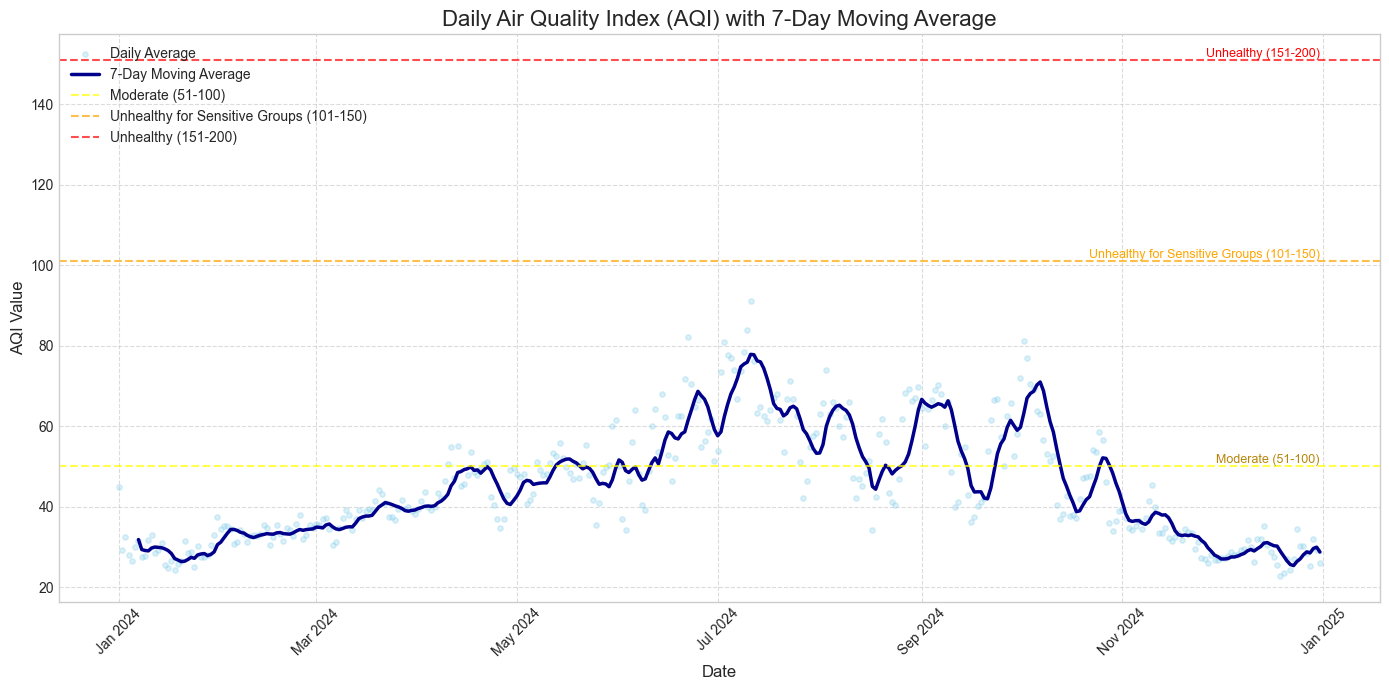

In [17]:
# For ozone concentration, define EPA standard reference lines
reference_lines = {
      0.055: ('yellow', 'Moderate (0.055-0.070 ppm)'),
      0.071: ('orange', 'Unhealthy for Sensitive Groups (0.071-0.085 ppm)'),
      0.086: ('red', 'Unhealthy (0.086-0.105 ppm)')
}

# Call the function with the ozone concentration column
daily_avg = plot_time_series(
      ozone_reduced, 
      'Daily Max 8-hour Ozone Concentration',
      title='Daily Ozone Concentration with 7-Day Moving Average',
      y_label='Ozone Concentration (ppm)',
      reference_lines=reference_lines
)

# For AQI values, define EPA standard reference lines
aqi_reference_lines = {
      50: ('yellow', 'Moderate (51-100)'),
      101: ('orange', 'Unhealthy for Sensitive Groups (101-150)'),
      151: ('red', 'Unhealthy (151-200)')
}

# Call the function with the AQI column
daily_aqi = plot_time_series(
      ozone_reduced, 
      'Daily AQI Value',
      title='Daily Air Quality Index (AQI) with 7-Day Moving Average',
      y_label='AQI Value',
      reference_lines=aqi_reference_lines
)

### Ozone Concentration Trends
- **Seasonal Pattern**: Ozone levels show a clear seasonal cycle, starting low in winter (~0.030 ppm), gradually rising through spring and peaking during summer months (June-September) at ~0.055-0.060 ppm, then declining back to winter levels.
- **Summer Pollution Events**: The highest concentrations occur during summer months, with several periods approaching or exceeding the "Moderate" threshold (0.055 ppm yellow line).
- **7-Day Moving Average**: The moving average (dark blue line) reveals sustained elevated periods during summer, particularly July-September, indicating consistent air quality challenges during warmer months.
- **Winter Recovery**: Clear improvement in air quality during late fall and winter months, with concentrations dropping well below health thresholds.

### AQI Value Trends  
- **Consistent Seasonal Pattern**: The AQI trends perfectly mirror the ozone concentration patterns, validating our data quality and EPA conversion formulas.
- **Summer Deterioration**: AQI values rise significantly during summer months, frequently crossing into the "Moderate" range (51-100) and occasionally approaching the "Unhealthy for Sensitive Groups" threshold.
- **Peak Summer Concerns**: July and August show the most concerning air quality periods, with some daily averages reaching 75-80 AQI.
- **Health Implications**: The elevated summer periods warrant public health attention, particularly for sensitive populations (children, elderly, those with respiratory conditions) who should be aware of outdoor activity limitations during peak summer months.

Both charts demonstrate California's classic Mediterranean air quality pattern, with clean winter air deteriorating during the warmer, sunnier summer months when photochemical ozone formation is enhanced. This seasonal pattern requires targeted summer air quality management strategies.